<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_9_cnn_part1/homework/hw_cnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1. Convolution

Implement a convolution function `conv(x, kernel, stride, pad)`, where:


* $\text{x}$: Two-dimensional array of size $(W,H)$;
* $\text{kernel}$: convolution kernel of size $(K, K)$;
* $\text{stride}$: convolution kernel stride. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: padding width on each side of the array. $\text{pad} > 0$.

The result of the function is to return the following value:
* $out$: Result of convolution of input data $\text{x}$, having size $(H', W')$:
   - $H' = 1 + (H + 2 \cdot pad - K)\ //\ stride$;
   - $W' = 1 + (W + 2 \cdot pad - K)\ //\ stride$.

---

Use the created `conv`[Sobel operator](https://en.wikipedia.org/w%D0%B5%D0%BB%D1%8F)
to the image, and then display the result on the screen.

You can work with both `numpy` and `torch` as you wish.

In [1]:
import torch
import numpy as np
import torch.nn.functional as F


In [2]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [13]:
def conv(x, kernel, stride, pad):    
    H = x.shape[0]
    W = x.shape[1]
    
    # padding x
    x = torch.from_numpy(x)
    x = F.pad(x, pad=(pad, pad, pad, pad), mode='constant', value=0)
    
    # calculating sizes for convolution
    K = kernel.shape[0]
    H_conv = 1 + (H + 2 * pad - K) // stride
    W_conv = 1 + (W + 2 * pad - K) // stride
    x_conv = torch.zeros((H_conv, W_conv))
    
    # x convolution
    row, col = 0, 0
    while row < H - K:
        while col < W - K:
            x_conv[row // stride][col // stride] = (x[row:(row+K), col:(col+K)] * kernel).sum()
            col += stride
        col = 0
        row += stride
    return x_conv.numpy()

In [4]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

In [7]:
conv(M, sobel_kernel_vert, stride=1, pad=1)

tensor([[ 6.,  6., -3.,  0.,  0.,  0.],
        [16.,  8., -4.,  0.,  0.,  0.],
        [19.,  8., -4.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

Apply these two filters to the following picture and draw the results:

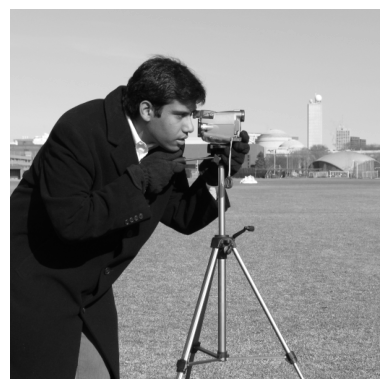

In [6]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

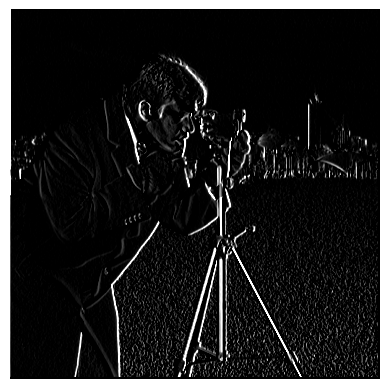

In [14]:
camera_conv = conv(camera, sobel_kernel_vert, stride=1, pad=1)
plt.figure()
plt.imshow(camera_conv.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

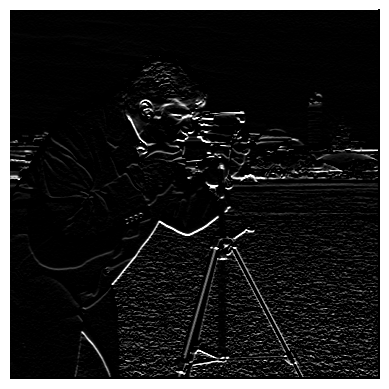

In [15]:
camera_conv = conv(camera, sobel_kernel_hor, stride=1, pad=1)
plt.figure()
plt.imshow(camera_conv.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Add the code below and interpret the result:O

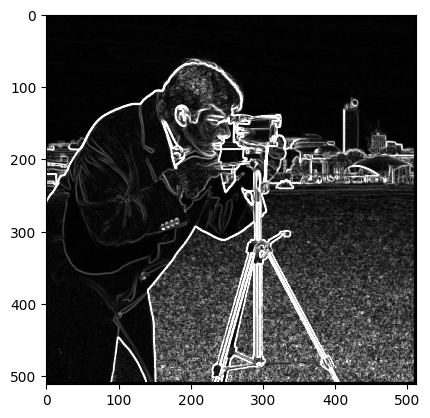

In [11]:
camera_s_hor_filter = conv(camera, sobel_kernel_hor, stride=1, pad=1)
camera_s_vert_filter = conv(camera, sobel_kernel_vert, stride=1, pad=1)
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

We amplified horizontal and vertical lines in the picture by applying Sobel operators (`sobel_kernel_vert` and `sobel_kernel_hor`, respectively). The resulted picture is an overlay of both masks with contrast borders.

## Task 2. AlexNet

Recreate the `AlexNet` architecture for plant disease detection. The datasets have already been created below.

In [16]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 10 # can be changed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
!curl https://storage.googleapis.com/ibeans/train.zip
!curl https://storage.googleapis.com/ibeans/validation.zip
!curl https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [18]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [19]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        
        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]
        
        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [20]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './train/'

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

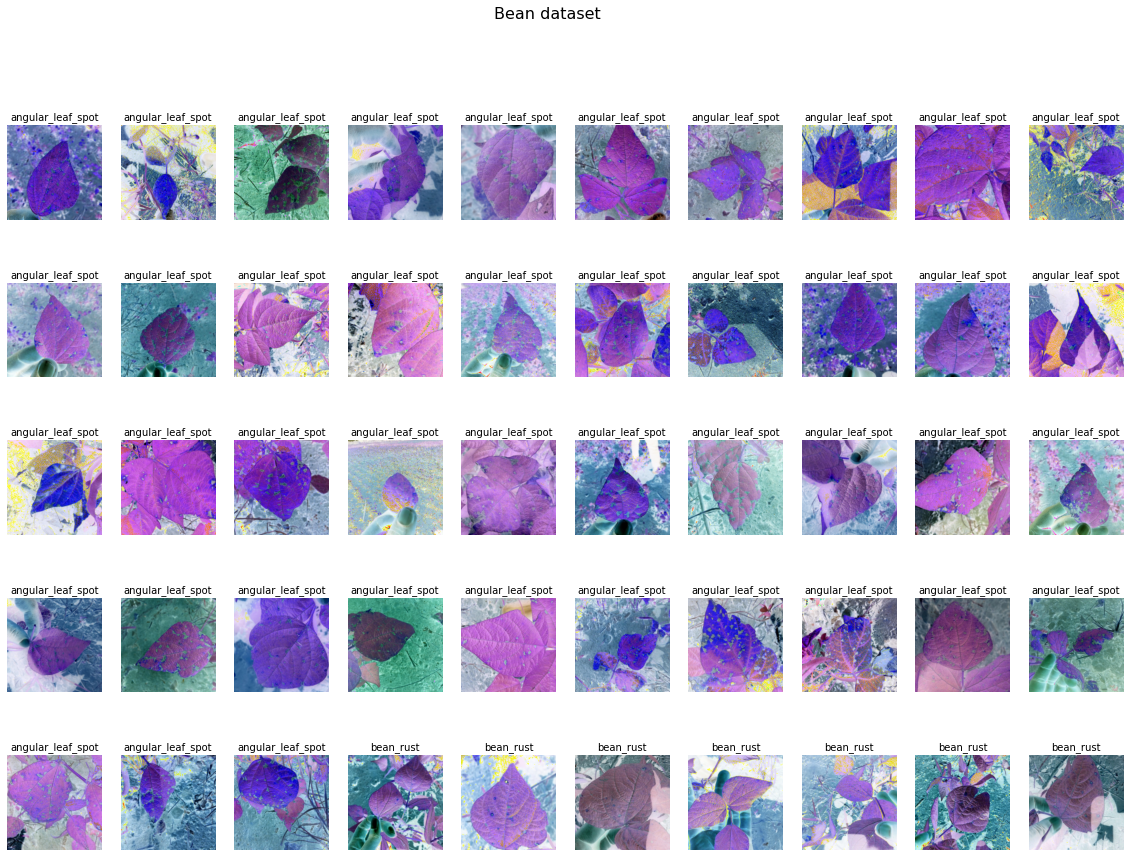

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

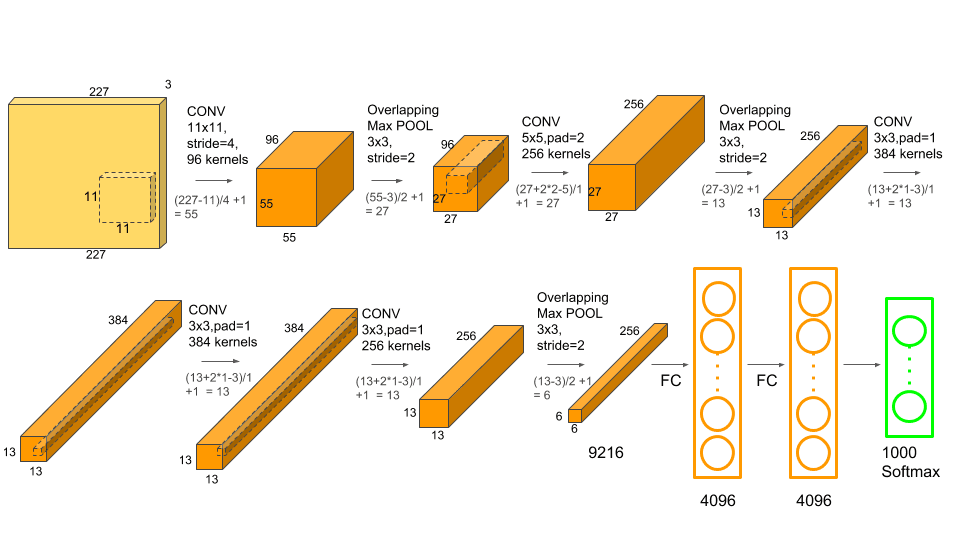

In [ ]:
N_CLASSES = # определите число классов в данных
LEARNING_RATE = 3e-4 # можно подобрать как-то другой)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE IS HERE

    def forward(self,x):
        # YOUR CODE IS HERE

        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [ ]:
model = AlexNet().to(DEVICE)
optimizer = # Оптимизатор
criterion = # Функция потерь

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');